# Hugging Faceを使用したFine Tuning

参考としたコード
- 主観と客観の感情分析データセット
  - https://github.com/ghmagazine/llm-book/blob/main/chapter5/5-2-sentiment-analysis-finetuning-wrime.ipynb

In [31]:
import torch
# GPUが使用可能か判断
if torch.cuda.is_available():
    print('gpu is available')
else:
    raise Exception('gpu is NOT available')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

gpu is available


device(type='cuda')

In [32]:
import sys
# Goole Colab環境か判断
def is_colabo():
    moduleList = sys.modules
    if 'google.colab' in moduleList:
        return True
    else:
        return False

# 実行環境が Jupyter Notebook か否かをチェックする関数
# https://blog.amedama.jp/entry/detect-jupyter-env
def is_env_notebook():
    """Determine wheather is the environment Jupyter Notebook"""
    if 'get_ipython' not in globals():
        # Python shell
        return False
    env_name = get_ipython().__class__.__name__
    if env_name == 'TerminalInteractiveShell':
        # IPython shell
        return False
    # Jupyter Notebook
    return True

In [33]:
# 必要なライブラリのインストール
if is_colabo():
    !pip install transformers[torch] datasets
    !pip install fugashi
    !pip install ipadic
    !pip install sentencepiece

# エラー対策（ランタイムを再起動する必要がある）
if is_colabo():
    !pip install git+https://github.com/huggingface/accelerate
    !pip install --upgrade transformers

In [34]:
from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
from transformers import Trainer
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import pandas as pd
import torch
import random

In [36]:
# 主観と客観の感情分析データセット
target_pattern = {
    'dataset_path': 'llm-book/wrime-sentiment',
    'dataset_name': '',
    'text_column': 'sentence',
}

print(target_pattern)

{'dataset_path': 'llm-book/wrime-sentiment', 'dataset_name': '', 'text_column': 'sentence'}


In [37]:
# データセットのロード
print(f"dataset :{target_pattern['dataset_path']}")
dataset = load_dataset(target_pattern['dataset_path'],
                       target_pattern['dataset_name'],
                       remove_neutral=False)
dataset

dataset :llm-book/wrime-sentiment


DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'user_id', 'datetime'],
        num_rows: 30000
    })
    validation: Dataset({
        features: ['sentence', 'label', 'user_id', 'datetime'],
        num_rows: 2500
    })
    test: Dataset({
        features: ['sentence', 'label', 'user_id', 'datetime'],
        num_rows: 2500
    })
})

In [38]:
# 実験のためデータセットを縮小したい場合はコチラを有効化
random.seed(42)
dataset = DatasetDict({
    "train": dataset['train'].select(
        random.sample(range(dataset['train'].num_rows), k=500)),
    "validation": dataset['validation'].select(
        random.sample(range(dataset['validation'].num_rows), k=500)),
    "test": dataset['test'].select(
        random.sample(range(dataset['test'].num_rows), k=500)),
})
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'user_id', 'datetime'],
        num_rows: 500
    })
    validation: Dataset({
        features: ['sentence', 'label', 'user_id', 'datetime'],
        num_rows: 500
    })
    test: Dataset({
        features: ['sentence', 'label', 'user_id', 'datetime'],
        num_rows: 500
    })
})

In [39]:
# トークナイザのロード
model_ckpt = "cl-tohoku/bert-base-japanese-whole-word-masking"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

100%|██████████| 500/500 [00:00<00:00, 9964.99it/s]


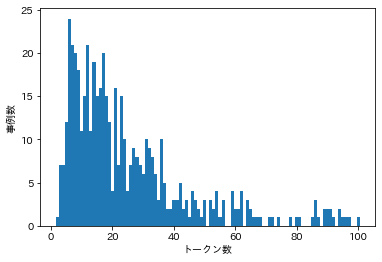

max: 100
95%: 94.0


100%|██████████| 500/500 [00:00<00:00, 8771.39it/s]


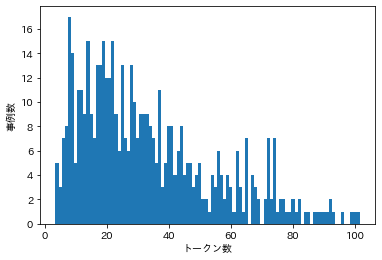

max: 101
95%: 92.55


In [40]:
# 大規模言語モデル入門に記載されているコードで視覚化して検証
from collections import Counter
import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
from datasets import Dataset
from tqdm import tqdm

# plt.rcParams["font.size"] = 18  # 文字サイズを大きくする

def visualize_text_length(dataset: Dataset):
    """データセット中のテキストのトークン数の分布をグラフとして描画"""
    # データセット中のテキストの長さを数える
    length_counter = Counter()
    for data in tqdm(dataset):
        length = len(tokenizer.tokenize(data["sentence"]))
        length_counter[length] += 1
    # length_counterの値から棒グラフを描画する
    if is_env_notebook():
        plt.bar(length_counter.keys(), length_counter.values(), width=1.0)
        plt.xlabel("トークン数")
        plt.ylabel("事例数")
        plt.show()
    print('max:',max(length_counter.keys()))
    PERCENT=95
    print(f'{PERCENT}%:',np.percentile([k for k in length_counter.keys()], PERCENT))

visualize_text_length(dataset['train'])
visualize_text_length(dataset['validation'])

トークナイズするときの最大長は100とする

In [41]:
# トークナイズ処理
def tokenize(batch):
    return tokenizer(batch[target_pattern['text_column']], padding=True, truncation=True, max_length=100)
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

In [42]:
# 事前学習モデルのロード
num_labels = len(set(dataset['train']['label']))
class_label = dataset['train'].features["label"]
label2id = {label: id for id, label in enumerate(class_label.names)}
id2label = {id: label for id, label in enumerate(class_label.names)}
model = (AutoModelForSequenceClassification
         .from_pretrained(
            model_ckpt, 
            num_labels=num_labels,
            label2id=label2id,  # ラベル名からIDへの対応を指定
            id2label=id2label,  # IDからラベル名への対応を指定
            )
         .to(device)
)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
import matplotlib.pyplot as plt

# メトリクスの定義
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

# グラフの表示
def show_graph(df, suptitle, regression, output='output.png'):
    suptitle_size = 23
    graph_title_size = 20
    legend_size = 18
    ticks_size = 13
    # 学習曲線
    fig = plt.figure(figsize=(20, 5))
    plt.suptitle(suptitle, fontsize=suptitle_size)
    # Train Loss
    plt.subplot(131)
    plt.title('Train Loss', fontsize=graph_title_size)
    plt.plot(df['loss'].dropna(), label='train')
    plt.legend(fontsize=legend_size)
    plt.yticks(fontsize=ticks_size)
    # Validation Loss
    plt.subplot(132)
    reg_str = f'$y={round(regression.coef_[0],5)}*x+{round(regression.intercept_,3)}$'
    plt.title(f'Val Loss', fontsize=graph_title_size)
    y = df['eval_loss'].dropna().values
    x = np.arange(len(y)).reshape(-1, 1)
    pred = regression.coef_ * x.ravel() + regression.intercept_  # 線形回帰直線
    plt.plot(y, color='tab:orange', label='val')
    plt.plot(pred, color='green', label='pred')
    plt.legend(fontsize=legend_size)
    plt.xlabel(reg_str, fontsize=ticks_size)
    plt.yticks(fontsize=ticks_size)
    # Accuracy/F1
    plt.subplot(133)
    plt.title('Accuracy/F1', fontsize=graph_title_size)
    plt.plot(df['eval_accuracy'].dropna(), label='accuracy')
    plt.plot(df['eval_f1'].dropna(), label='F1')
    plt.legend(fontsize=legend_size)
    plt.yticks(fontsize=ticks_size)
    plt.tight_layout()
    plt.savefig(output)
    # plt.show()
    plt.close(fig)

# 選択したハイパーパラメータ文字列
def get_hyperparam_str(index, param):
    idx = str(index).zfill(3)
    param_str = ', '.join([f'{key}:{param[key]}' for key in param.index.to_list()[:-1]])
    # return f'{idx}: [{param_str}]'
    return idx, param_str

In [52]:
# ハイパーパラメータ一覧を読み込む
import pandas as pd
param_path = 'data/hyper_parameters_test.csv'       # テスト用
# param_path = 'data/hyper_parameters.csv'          # 全部
# param_path = 'data/hyper_parameters_0-23.csv'     # 9/23 15:50
# param_path = 'data/hyper_parameters_24_119.csv'   # 9/23 20:25
params_df = pd.read_csv(param_path, index_col=0)
target_params = params_df[params_df['target']]

In [53]:
# 試しに表示してみる
for index, param in target_params.iterrows():
    print('-'*100)
    id, param_str = get_hyperparam_str(index, param)
    print(f'{id}: [{param_str}]')
    print('-'*100)

----------------------------------------------------------------------------------------------------
000: [epoch:2, type:constant, lr:5e-06, batch:16, weight_decay:0.0, accumulation_steps:1.0]
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
023: [epoch:2, type:constant, lr:5e-06, batch:128, weight_decay:0.001, accumulation_steps:4.0]
----------------------------------------------------------------------------------------------------


In [46]:
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta, timezone
from datetime import datetime, timedelta, timezone

# 回帰直線をひく
def linear_regression(history_df):
    y = history_df['eval_loss'].dropna().values
    x = np.arange(len(y)).reshape(-1, 1)
    linear = LinearRegression().fit(x, y)
    return linear

# 結果ファイル名
def result_filename():
    JST = timezone(timedelta(hours=+9), 'JST')
    filename = f"result/result_{datetime.now(JST).strftime('%Y%m%d_%H%M%S')}.csv"
    return filename

# 結果保存用フォルダ名
def result_dirname():
    JST = timezone(timedelta(hours=+9), 'JST')
    dirname = f"outputs/result_{datetime.now(JST).strftime('%Y%m%d_%H%M%S')}"
    return dirname

In [47]:
import pynvml
# GPU使用量
def print_gpu_utilization():
    pynvml.nvmlInit()
    handle = pynvml.nvmlDeviceGetHandleByIndex(0)
    info = pynvml.nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")

# サマリー表示
def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()

In [54]:
# 訓練設定
def get_train_arg(output_dir, hyper_parameter):
    args = TrainingArguments(
        output_dir=output_dir,                                # 結果の保存フォルダ
        num_train_epochs=hyper_parameter['epoch'],            # エポック数
        learning_rate=hyper_parameter['lr'],                  # 学習率
        per_device_train_batch_size=hyper_parameter['batch'], # 訓練時のバッチサイズ
        gradient_accumulation_steps=hyper_parameter['accumulation_steps'],  # 勾配累積のサイズ
        gradient_checkpointing=True,                          # 勾配チェックポイント
        per_device_eval_batch_size=hyper_parameter['batch'],  # 評価時のバッチサイズ
        weight_decay=hyper_parameter['weight_decay'],         # 正則化
        disable_tqdm=False,                                   # プログレスバー非表示
        logging_strategy="epoch",                             # ロギングのタイミング
        # logging_steps=hyper_parameter['batch'],               # ロギングのタイミング
        evaluation_strategy="epoch",                          # 検証セットによる評価のタイミング
        save_strategy="epoch",                                # チェックポイントの保存タイミング
        load_best_model_at_end=True,                          # 訓練後に開発セットで最良のモデルをロード
        metric_for_best_model="eval_loss",                    # 最良のモデルを決定する評価指標
        greater_is_better=False,                              # eval_lossは小さいほどよい
        log_level="error",                                    # ログレベル
        fp16=True,                                            # 量子化
        lr_scheduler_type=hyper_parameter['type'],            # "constant", "linear", "cosine"
        optim='adafactor',
    )
    return args

In [55]:
import os
import pandas as pd
import numpy as np
from transformers import EarlyStoppingCallback

# デバッグ用定数
DEV_DEBUG = True

# 保存フォルダ
dir_name = result_dirname()
os.makedirs(dir_name)
# 結果保存用リスト
hyper_parameters = []

for idx, hyper_parameter in target_params.iterrows():
    # hyper_parameter = hyper_parameters[idx]
    id, param_str = get_hyperparam_str(idx, hyper_parameter)
    print('-'*100)
    print(f'{id}: [{param_str}]')
    print('-'*100)
    # モデルや画像の保存先
    result_save_dir = f'{dir_name}/param{id}'
    model_save_dir = f'{result_save_dir}/model'
    # print(result_save_dir, model_save_dir)
    # model_name = target_pattern['save_dir']

    # 訓練用の設定
    training_args = get_train_arg(model_save_dir, hyper_parameter)
    # Trainerの定義
    trainer = Trainer(
        model=model,                                # モデル
        args=training_args,                         # 学習パラメータ
        compute_metrics=compute_metrics,            # メトリクス
        train_dataset=dataset_encoded["train"],     # 訓練データ
        eval_dataset=dataset_encoded["validation"], # 検証データ
        tokenizer=tokenizer,                        # トークナイザ
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    )

    # トレーニング実行
    result = trainer.train()
    trainer.save_model(model_save_dir)

    # ログ
    history_df = pd.DataFrame(trainer.state.log_history)
    history_df.to_csv(f'{result_save_dir}/history.csv')

    # 線形回帰
    reg = linear_regression(history_df)

    # 結果を表示
    show_graph(history_df, param_str, reg, f'{result_save_dir}/output{id}.png')  # ?

    # ログ追加
    hyper_parameter['train_loss'] = history_df['loss'].dropna().values
    hyper_parameter['val_loss'] = history_df['eval_loss'].dropna().values
    hyper_parameter['coef'] = 1 if reg.coef_[0] > 0 else -1
    hyper_parameters.append(hyper_parameter)
    # GPU使用量確認
    if DEV_DEBUG: print_summary(result)
    # break

# 結果を保存
result_df = pd.DataFrame(hyper_parameters)
filename = f"{dir_name}/result.csv"
result_df.to_csv(filename)
print(f"save file: {filename}")

----------------------------------------------------------------------------------------------------
000: [epoch:2, type:constant, lr:5e-06, batch:16, weight_decay:0.0, accumulation_steps:1.0]
----------------------------------------------------------------------------------------------------


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.812800,1.004682,0.482000,0.454158
2,0.701100,0.954131,0.516000,0.504354


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.w

Time: 5.53
Samples/second: 180.84
GPU memory occupied: 3011 MB.
----------------------------------------------------------------------------------------------------
023: [epoch:2, type:constant, lr:5e-06, batch:128, weight_decay:0.001, accumulation_steps:4.0]
----------------------------------------------------------------------------------------------------


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.692900,0.950453,0.542000,0.529310
2,0.670500,0.950364,0.550000,0.535421


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.w

Time: 3.43
Samples/second: 291.61
GPU memory occupied: 4095 MB.
save file: outputs/result_20230924_194133/result.csv
